
ilk deneme, elips1.pt'de kayıtlı. 0.05 başarı oranı, çok fena
ikinci denemede normalizasyonu kaldırdım. aynı sonuç, sorun var.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [11]:
train_transform = transforms.Compose([
#     transforms.RandomRotation(10),
#     transforms.RandomHorizontalFlip(),
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #  GÖZDEN GEÇECEK
#     transforms.Normalize([0,0,0], [1,1,1])
])

In [12]:
dataset = datasets.ImageFolder('shapes_dataset_HR',transform=train_transform)
torch.manual_seed(42)
train_data, test_data = torch.utils.data.random_split(dataset, [9000, 1000])

train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10)

In [13]:
len(train_data)

9000

In [14]:
train_data.dataset.classes

['0', '1', '2', '3', '4', '5']

In [15]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,7,1,3)
        self.conv2 = nn.Conv2d(6,16,3,1,1)
        self.conv3 = nn.Conv2d(16,384,1,1)
        self.fc1 = nn.Linear(56*56*384,64)
        self.fc2 = nn.Linear(64,6)
#         self.fc2 = nn.Linear(120,84)
#         self.fc3 = nn.Linear(84,6)
        
    def forward(self,X): # POOLING YERINE STRIDE KULLAN
        X = self.conv1(X)
        X = F.max_pool2d(X,2,2) #BATCH NORM LAYER'I AT RELU'DAN ÖNCE
        X = self.conv2(X)
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3(X))
        # X = F.max_pool2d(X,2,2)
        X = X.view(-1,56*56*384)
#         X = F.relu(self.fc1(X))
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return F.log_softmax(X,dim=1)
        

In [16]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

In [17]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 384, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=1204224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

In [18]:
import time
start_time = time.time()

epochs = 30

# # LIMITS on num of batches, sadece daha hızlı bitsin diye, bize lazım değil
# max_trn_batch = 800 # batch 10 images --> 8000 images
# max_tst_batch = 300 # 3000 max images

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
#         # optional limit number of batches
#         if b == max_trn_batch:
#             break
            
        b+=1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%300 == 0:
            acc = trn_corr.item()/b
            print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
#             if b == max_tst_batch:
#                 break
        
            y_val = CNNmodel(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'total time = {total_time/60} mins')

Epoch 0 batch 300 loss: 1.7830266952514648 accuracy: 1.7766666666666666
Epoch 0 batch 600 loss: 1.8065744638442993 accuracy: 1.745
Epoch 0 batch 900 loss: 1.7993097305297852 accuracy: 1.68
Epoch 1 batch 300 loss: 1.8044354915618896 accuracy: 1.8333333333333333
Epoch 1 batch 600 loss: 1.8029155731201172 accuracy: 1.7683333333333333
Epoch 1 batch 900 loss: 1.800292730331421 accuracy: 1.758888888888889
Epoch 2 batch 300 loss: 1.7927939891815186 accuracy: 1.6433333333333333
Epoch 2 batch 600 loss: 1.7836291790008545 accuracy: 1.7616666666666667
Epoch 2 batch 900 loss: 1.7955796718597412 accuracy: 1.758888888888889
Epoch 3 batch 300 loss: 1.779036521911621 accuracy: 1.7566666666666666
Epoch 3 batch 600 loss: 1.773716926574707 accuracy: 1.7416666666666667
Epoch 3 batch 900 loss: 1.800920844078064 accuracy: 1.758888888888889
Epoch 4 batch 300 loss: 1.7907978296279907 accuracy: 1.76
Epoch 4 batch 600 loss: 1.7869014739990234 accuracy: 1.75
Epoch 4 batch 900 loss: 1.7963110208511353 accuracy: 1

In [78]:
torch.save(CNNmodel.state_dict(), 'elips2_3.pt')

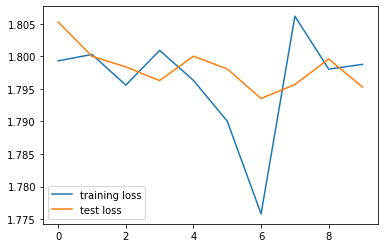

In [79]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.legend()

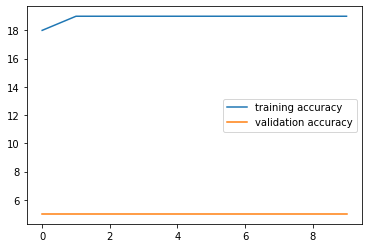

In [80]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.legend()

In [81]:
test_correct[-1].item()/3000

0.05366666666666667